In [4]:
#Importing required libraries
import numpy as np
import random
from decimal import Decimal, ROUND_DOWN
import cmath

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
#Physical properties
wavelength = 813.4e-9   
focal_dist = 4e-3       #focal length of the lens
beam_width = 2e-3       #radius of the input beam
aperture = 4e-3         #aperture diameter of the lens


#Simulation variables
xmin = -50e-3   # Simulating 100X100 mm^2 grid
xmax = 50e-3
ymin = -50e-3
ymax = 50e-3
xlen = xmax-xmin  #calculating total length, later used to find dx
ylen = ymax-ymin


N = 4000      #X-Size of the matrix for performing simulation
M = 4000      #Y-Size of the matrix for performing simulation

dx = xlen/N   #X-Sampling size
dy = ylen/M   #Y-Sampling size

print(dx,dy)

x = np.arange(xmin,xmax,dx)   #X-line_space
y = np.arange(ymin,ymax,dy)   #Y-line_space


X,Y = np.meshgrid(x,y)   #defining meshgrid


def circ(x):    #Circ function for simulating aperture
    return  (abs(x)<=1/2).astype(np.int)


2.5e-05 2.5e-05


In [6]:
normalizing_factor = (1e-3/((np.pi*beam_width**2)/2))   #normalzing to 1mW power
input_beam = normalizing_factor*np.exp(-2*((X/beam_width)**2 + (Y/(beam_width))**2))  #Intensity

In [7]:
inp_power = np.trapz(np.trapz(input_beam))*dx*dy  #1mW power (Integration of Intensity)
print('Input power = ' + str(1e3*inp_power) + ' mW')

Input power = 1.0000000000002205 mW


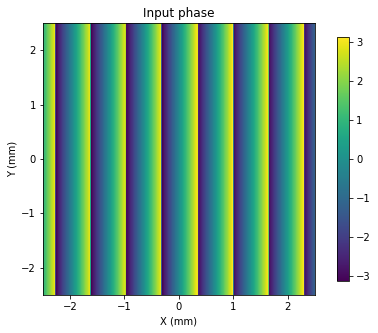

In [9]:
phase_maskx = np.exp(1j*(2*np.pi/(wavelength*focal_dist))*((5e-6)*X)) #(2pi/(lambda*f)*[shift distance]*[X/Y]

#For moving a single spot in focused plane, we generally se linear ramp [-pi,pi]
slicing = 1900
extent = [(xmin + slicing*dx)*1e3, (xmax - slicing*dx)*1e3,(ymin + slicing*dy)*1e3,(ymax - slicing*dy)*1e3]
plt.figure(figsize=(8,5))
plt.title('Input phase')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.xticks(np.arange(-15,15,1))
plt.yticks(np.arange(-15,15,1))
plt.imshow(np.angle(phase_maskx)[slicing:N-slicing,slicing:M-slicing],extent = extent,origin = 'lower')
plt.colorbar(shrink=0.9)

In [10]:
def fraunhofer(inp,xlen,ylen,wavelen,z):
    M,N = inp.shape

    dx = xlen/N    #finding sampling size
    dy = ylen/M
    
    k = 2*np.pi/wavelen  #wave-vector

    LX = wavelen*z/dx    #Calculating image plane X-Len 
    LY = wavelen*z/dy    #Calculating image plane Y-Len

    DX = wavelen*z/xlen  #Calculating image plane X-Sampling
    DY = wavelen*z/ylen  #Calculating image plane Y-Sampling
    
    x2 = np.arange(-LX/2,LX/2-(DX/2),DX)
    y2 = np.arange(-LY/2,LY/2-(DY/2),DY)
    
    X2,Y2 = np.meshgrid(x2,y2)  #meshgrid for image plane

    exp_term = 1/(1j*wavelen*z)
    
    outp = exp_term*np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(inp)))*dx*dy

    
    #print('X & Y side lengths = ' + str(LX) +' ' + str(LY))
    #print('X & Y sampling size = ' + str(DX) +' ' + str(DY))
    
    return outp,LX,LY,DX,DY,x2,y2

In [11]:
#Multiplying the phase while focusing
#Always keep the input beam untouched to multiply different phases later on
focused_beam,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*phase_maskx,xlen,ylen,wavelength,focal_dist)

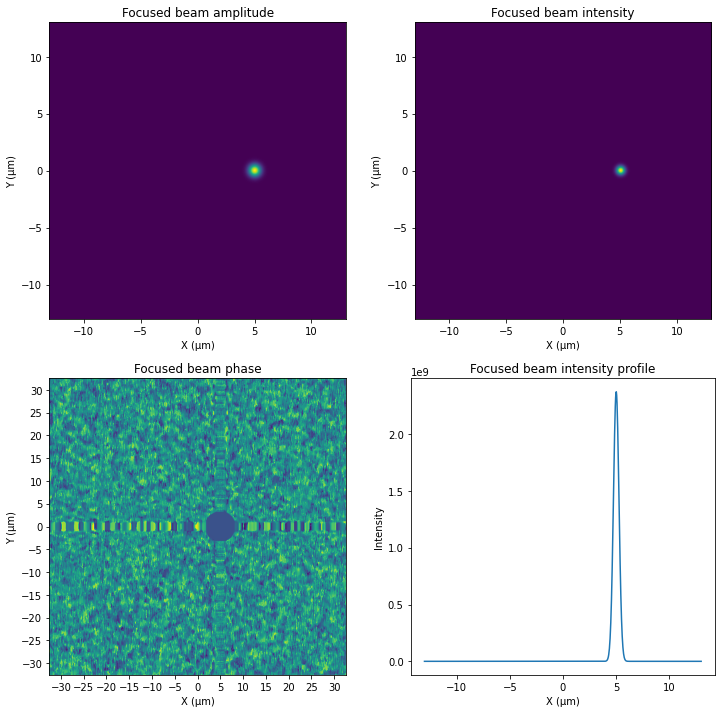

In [13]:
fig, ax = plt.subplots(2,2,figsize=(12, 12))

slicing = 1600
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
ax[0][0].set_title('Focused beam amplitude')
ax[0][0].set_xlabel('X (\u03bcm)')
ax[0][0].set_ylabel('Y (\u03bcm)')
ax[0][0].set_xticks(np.arange(-10,11,5))
ax[0][0].set_yticks(np.arange(-10,11,5))
ax[0][0].imshow(abs(focused_beam)[slicing:N-slicing,slicing:M-slicing],extent = extent,origin = 'lower')


slicing = 1600
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
ax[0][1].set_title('Focused beam intensity')
ax[0][1].set_xlabel('X (\u03bcm)')
ax[0][1].set_ylabel('Y (\u03bcm)')
ax[0][1].set_xticks(np.arange(-10,11,5))
ax[0][1].set_yticks(np.arange(-10,11,5))
ax[0][1].imshow(abs(focused_beam*focused_beam)[slicing:N-slicing,slicing:M-slicing],extent = extent,origin='lower')

slicing = 1000
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
ax[1][0].set_title('Focused beam phase')
ax[1][0].set_xlabel('X (\u03bcm)')
ax[1][0].set_ylabel('Y (\u03bcm)')
ax[1][0].set_xticks(np.arange(-40,41,5))
ax[1][0].set_yticks(np.arange(-40,41,5))
ax[1][0].imshow(np.angle(focused_beam)[slicing:N-slicing,slicing:M-slicing],extent = extent,origin = 'lower')

slicing = 1600
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
ax[1][1].set_title('Focused beam intensity profile')
ax[1][1].set_xlabel('X (\u03bcm)')
ax[1][1].set_ylabel('Intensity')
ax[1][1].set_xticks(np.arange(-10,11,5))
ax[1][1].plot(1e6*x2[slicing:N-slicing],abs(focused_beam*focused_beam)[int(N/2)][slicing:N-slicing])

plt.show()

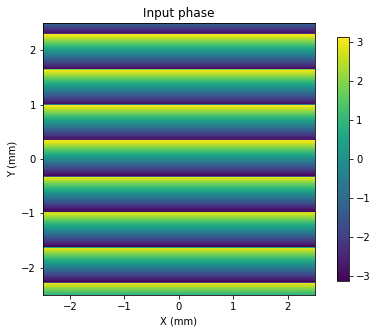

In [16]:
phase_masky = np.exp(1j*(2*np.pi/(wavelength*focal_dist))*((5e-6)*Y)) #For shifting in Y direction

slicing = 1900
extent = [(xmin + slicing*dx)*1e3, (xmax - slicing*dx)*1e3,(ymin + slicing*dy)*1e3,(ymax - slicing*dy)*1e3]
plt.figure(figsize=(8,5))
plt.title('Input phase')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.xticks(np.arange(-15,15,1))
plt.yticks(np.arange(-15,15,1))
plt.imshow(np.angle(phase_masky)[slicing:N-slicing,slicing:M-slicing],extent = extent,origin = 'lower')
plt.colorbar(shrink=0.9)

In [17]:
#Multiplying the phase while focusing
focused_beam,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*phase_masky,xlen,ylen,wavelength,focal_dist)

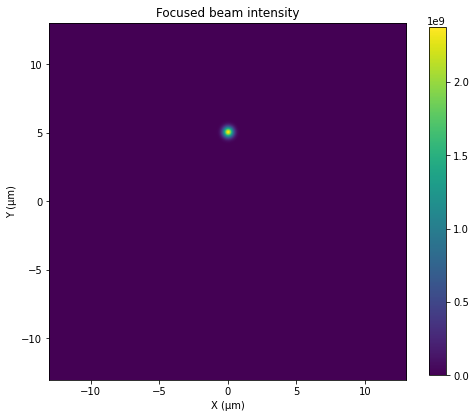

In [19]:
slicing = 1600
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
plt.figure(figsize=(8,8))
plt.title('Focused beam intensity')
plt.xlabel('X (\u03bcm)')
plt.ylabel('Y (\u03bcm)')
plt.xticks(np.arange(-10,11,5))
plt.yticks(np.arange(-10,11,5))
plt.imshow(abs(focused_beam**2)[slicing:N-slicing,slicing:M-slicing],extent = extent,origin='lower')
plt.colorbar(shrink=0.8)

In [20]:
#Adding above two phases [Wrong because the input power is multiplied by 2]
focused_beam,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*(phase_maskx + phase_masky),xlen,ylen,wavelength,focal_dist)

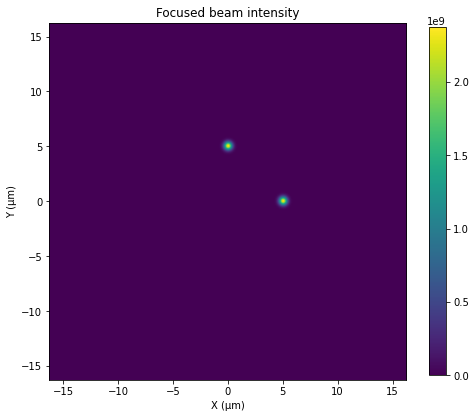

In [22]:
slicing = 1500
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
plt.figure(figsize=(8,8))
plt.title('Focused beam intensity')
plt.xlabel('X (\u03bcm)')
plt.ylabel('Y (\u03bcm)')
plt.xticks(np.arange(-15,15.1,5))
plt.yticks(np.arange(-15,15.1,5))
plt.imshow(abs(focused_beam**2)[slicing:N-slicing,slicing:M-slicing],extent = extent,origin='lower')
plt.colorbar(shrink=0.8)

In [23]:
#Correct way to add two phase profiles
focused_beam,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*np.exp(1j*np.angle(phase_maskx + phase_masky)),xlen,ylen,wavelength,
                                            focal_dist)

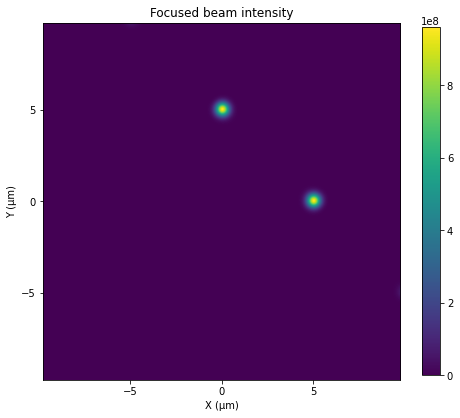

In [26]:
slicing = 1700
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
plt.figure(figsize=(8,8))
plt.title('Focused beam intensity')
plt.xlabel('X (\u03bcm)')
plt.ylabel('Y (\u03bcm)')
plt.xticks(np.arange(-10,15.1,5))
plt.yticks(np.arange(-10,15.1,5))
plt.imshow(abs(focused_beam**2)[slicing:N-slicing,slicing:M-slicing],extent = extent,origin='lower')
plt.colorbar(shrink=0.8)

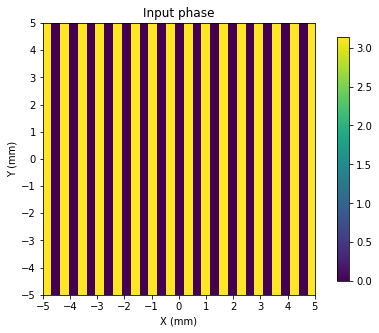

In [34]:
phase_maskx1 = np.exp(1j*(2*np.pi/(wavelength*focal_dist))*((5e-6)*X))
phase_maskx2 = np.exp(1j*(2*np.pi/(wavelength*focal_dist))*((-5e-6)*X))

#Addition of two linear ramps(with same aboslute dispalcement) results in a binary grating
total_mask = phase_maskx1 + phase_maskx2

slicing = 1800
extent = [(xmin + slicing*dx)*1e3, (xmax - slicing*dx)*1e3,(ymin + slicing*dy)*1e3,(ymax - slicing*dy)*1e3]
plt.figure(figsize=(8,5))
plt.title('Input phase')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.xticks(np.arange(-15,15,1))
plt.yticks(np.arange(-15,15,1))
plt.imshow(np.angle(total_mask)[slicing:N-slicing,slicing:M-slicing],extent = extent,origin = 'left')
plt.colorbar(shrink=0.9)

In [53]:
#focused_beam,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*total_mask,xlen,ylen,wavelength,focal_dist)  #Incorrect
focused_beam,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*np.exp(1j*np.angle(total_mask)),xlen,ylen,wavelength,focal_dist)

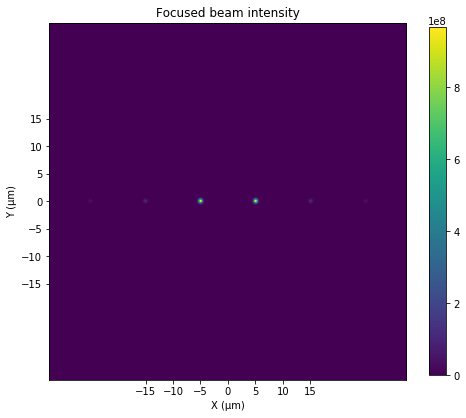

In [54]:
#With pi phase depth, power carried by 1st order is 80%(40% in each)
#Because of the presence of sinc function, we only see the higher order odd terms only (even terms are 0)
slicing = 1000
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
plt.figure(figsize=(8,8))
plt.title('Focused beam intensity')
plt.xlabel('X (\u03bcm)')
plt.ylabel('Y (\u03bcm)')
plt.xticks(np.arange(-15,15.1,5))
plt.yticks(np.arange(-15,15.1,5))
plt.imshow(abs(focused_beam**2)[slicing:N-slicing,slicing:M-slicing],extent = extent,origin='left')
plt.colorbar(shrink=0.8)

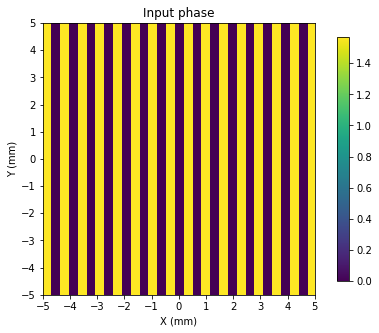

In [43]:
#Changing the phase depth to pi/2
slicing = 1800
extent = [(xmin + slicing*dx)*1e3, (xmax - slicing*dx)*1e3,(ymin + slicing*dy)*1e3,(ymax - slicing*dy)*1e3]
plt.figure(figsize=(8,5))
plt.title('Input phase')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.xticks(np.arange(-15,15,1))
plt.yticks(np.arange(-15,15,1))
plt.imshow(0.5*np.angle(total_mask)[slicing:N-slicing,slicing:M-slicing],extent = extent,origin = 'left')
plt.colorbar(shrink=0.9)

In [58]:
focused_beam,LX,LY,DX,DY,x2,y2 = fraunhofer((input_beam**0.5)*np.exp(0.5j*np.angle(total_mask)),xlen,
                                            ylen,wavelength,focal_dist)

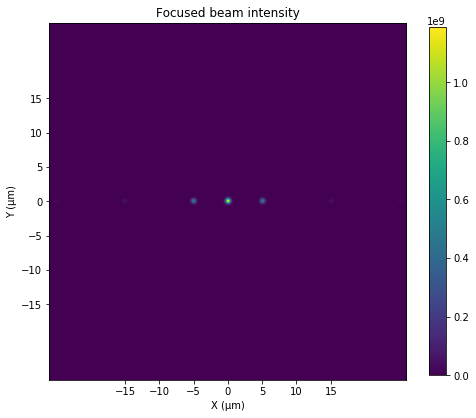

In [59]:
#With pi/2 phase depth 0th order carries 50% of input power
#Because of the presence of sinc function, we only see the higher order odd terms only (even terms are 0)
slicing = 1200
extent = [(-LX/2 + slicing*DX)*1e6, (LX/2 - slicing*DX)*1e6,(-LY/2 + slicing*DY)*1e6,(LY/2 - slicing*DY)*1e6]
plt.figure(figsize=(8,8))
plt.title('Focused beam intensity')
plt.xlabel('X (\u03bcm)')
plt.ylabel('Y (\u03bcm)')
plt.xticks(np.arange(-15,15.1,5))
plt.yticks(np.arange(-15,15.1,5))
plt.imshow(abs(focused_beam**2)[slicing:N-slicing,slicing:M-slicing],extent = extent,origin='left')
plt.colorbar(shrink=0.8)

In [48]:
1e3*np.trapz(np.trapz(abs(focused_beam)**2))*DX*DY #total power in image plane = 1mW

0.9998522620435834

In [49]:
25*DX #number of pixels to cover the complete beam (beam radius is ~0.74 um)

8.134e-07

In [60]:
#function to calculate power (peak intensities have to be within error margin)
def calculate_power(beam,error,spot_rad):
    peaks = np.where(abs(beam**2)>=abs(beam**2).max() - error)  #finding all peaks within error
    print('Number of spots = ' + str(len(peaks[0]))) #printing number of spots detected
    power_each = np.zeros(len(peaks[0]))            #Array to store power carried by each spot
    for i in range(len(peaks[0])):
        #Integrating intensity over the spot (spot is identified using the peak)
        power_each[i] = np.trapz(np.trapz(abs(beam**2)[peaks[0][i]-spot_rad:peaks[0][i]+spot_rad,peaks[1][i]-spot_rad:peaks[1][i]+spot_rad]))*DX*DY
        print(power_each[i])
    max_I = power_each.max()   #Max power
    min_I = power_each.min()   #Min power
    #print(max_I,min_I)
    return len(peaks[0]),max_I,min_I,1-((max_I - min_I)/(max_I + min_I))

In [61]:
num_peaks,maxI,minI,uniformity = calculate_power(focused_beam,1e6,25) 

Number of spots = 1
0.0004978526065481596
